# Smart Supply Chain Assistant: AI-Powered Demand Forecasting & Order Planning

## 🧠 Problem Statement

In traditional supply chain planning, forecasting future demand and deciding when to reorder stock requires deep domain knowledge, time-consuming analysis, and often suffers from inaccurate estimates. Errors in planning can lead to overstock, stockouts, or increased logistics costs.

As businesses grow and datasets become more complex, there's a strong need for intelligent tools that can interpret past data, generate structured reorder plans, and simulate “what-if” scenarios—without requiring technical expertise.

## 🤖 Proposed Solution

We propose a **Generative AI-powered assistant** that enables supply chain managers to:

- Ask natural language questions about product demand trends.
- Generate accurate **forecast suggestions** based on historical data.
- Automatically produce **structured reorder plans** in JSON format, ready for ERP systems.
- Retrieve supporting data (e.g., past demand, supplier details) using **RAG (Retrieval-Augmented Generation)**.

This assistant leverages multiple Generative AI capabilities including:

- **Few-shot Prompting** to guide the model in forecasting based on past trends.
- **Structured Output** to generate valid, machine-consumable JSON order plans.
- **Retrieval-Augmented Generation (RAG)** to dynamically fetch relevant past data and supplier information.

The result is an intuitive, low-code solution to help businesses improve planning efficiency and decision-making in the supply chain.

---

🔎 Follow along as we explore how GenAI can modernize the core of logistics and planning!


In [1]:

!pip install -U -q "google-genai==1.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.7 MB/s eta 0:00:00


In [2]:
from google import genai
from google.genai import types

from IPython.display import HTML, Markdown, display

In [3]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

In [5]:
import pandas as pd

# Load your dataset
df = pd.read_csv('/kaggle/input/supply-chain-demand-data-csv/supply_chain_demand_data.csv')

# Preview it
df.head()


,stock_code,product_name,month,demand,supplier_id,supplier_name
0,A123,Wooden Chair,Jan-24,120,S456,SmartFurnish Co.
1,A123,Wooden Chair,Feb-24,130,S456,SmartFurnish Co.
2,A123,Wooden Chair,Mar-24,140,S456,SmartFurnish Co.
3,A123,Wooden Chair,Apr-24,145,S456,SmartFurnish Co.
4,A123,Wooden Chair,May-24,150,S456,SmartFurnish Co.


## Structured Output with JSON Mode

In this section, we use Generative AI to produce a structured order plan based on predicted demand. The output will follow a standard JSON format that could be easily used in ERP systems.

This simulates how a supply chain planner can ask the assistant for a recommendation and receive an actionable, machine-readable response.


In [6]:
# Install the Google Generative AI SDK if you haven't already
!pip install -q google-generativeai

# Import necessary libraries
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

# Retrieve your API key securely
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

# Configure the API key
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize the Gemini model
model = genai.GenerativeModel("gemini-1.5-flash")  # or "gemini-1.5-pro"

# Forecast prompt
forecast_prompt = """
You are a smart supply chain assistant. Predict next month’s demand based on previous trends.

Example 1:
Jan: 100
Feb: 110
Mar: 120
Apr: ?
Answer: 130

Example 2:
Jan: 120
Feb: 130
Mar: 140
Apr: 145
May: ?
Answer:
"""

# Generate the response
response = model.generate_content(forecast_prompt)

# Print the prediction
print("Predicted Demand:", response.text.strip())


Predicted Demand: In Example 2, the increase isn't perfectly linear.  Let's analyze the changes:

* Jan to Feb: +10
* Feb to Mar: +10
* Mar to Apr: +5

The rate of increase is slowing down.  A simple prediction would be to assume a further decrease in the rate of increase.  A conservative estimate would be to predict a smaller increase than the 5 seen in the previous month.  Let's assume an increase of 3 or 4.

Therefore, a reasonable prediction for May's demand would be **148 or 149**.  A more sophisticated model (e.g., exponential smoothing or ARIMA) could provide a more precise forecast, but with only five data points, a simple linear-ish extrapolation with a decreasing rate of change is appropriate.


In [7]:
from datetime import datetime, timedelta

# Get today's and delivery date
order_date = datetime.today().strftime('%Y-%m-%d')
expected_delivery_date = (datetime.today() + timedelta(days=10)).strftime('%Y-%m-%d')

# Prompt with dynamic dates
order_plan_prompt = f"""
You are a smart supply chain assistant. Based on the forecasted demand, generate a structured order plan in JSON format.

Product ID: A123  
Product Name: Wooden Chair  
Predicted Demand: 147.5  
Preferred Supplier: SmartFurnish Co. (Supplier ID: S456)

The output should be valid JSON and include:
- product_id
- product_name
- recommended_quantity
- supplier_id
- supplier_name
- order_date (assume today's date)
- expected_delivery_date (assume 10 days after order date)

Output:
Today's date: {order_date}
"""

# Generate content using the correct model object
response = model.generate_content(order_plan_prompt)

print("Generated JSON Order Plan:\n", response.text.strip())


Generated JSON Order Plan:
 ```json
{
  "order_plan": [
    {
      "product_id": "A123",
      "product_name": "Wooden Chair",
      "recommended_quantity": 148,
      "supplier_id": "S456",
      "supplier_name": "SmartFurnish Co.",
      "order_date": "2025-05-24",
      "expected_delivery_date": "2025-06-03"
    }
  ]
}
```


In [8]:
# Filter the last 3 months of demand for product A123
recent_data = df[df["stock_code"] == "A123"].tail(3)
data_str = recent_data.to_string(index=False)

print(data_str)


stock_code product_name  month  demand supplier_id    supplier_name
      A123 Wooden Chair Mar-24     140        S456 SmartFurnish Co.
      A123 Wooden Chair Apr-24     145        S456 SmartFurnish Co.
      A123 Wooden Chair May-24     150        S456 SmartFurnish Co.


In [9]:
# Sample demand data string (replace with your actual data)
data_str = """
Jan: 100
Feb: 110
Mar: 120
Apr: 135
May: 147.5
"""

# Prompt for trend analysis and reorder suggestion
rag_prompt = f"""
You are a supply chain analyst. Based on the following demand data, summarize the trend and suggest if the product should be reordered.

Here is the data:
{data_str}

Please respond with a short summary in natural language.
"""

# Generate the response using the Gemini model
rag_response = model.generate_content(rag_prompt)

# Print the natural language summary
print("RAG Summary:\n", rag_response.text.strip())



RAG Summary:
 Demand for this product is showing a clear upward trend, increasing each month.  Given this consistent growth, a reorder is recommended, but the quantity should consider the projected continued increase in demand.  A more detailed forecast, factoring in potential seasonality and other market factors, would help determine the optimal reorder quantity and timing.


In [10]:
def supply_chain_assistant(user_query):
    prompt = f"""
    You are a smart supply chain assistant. Answer the user's query based on supply chain data and your reasoning.

    Demand data:
    {df[df["stock_code"] == "A123"].to_string(index=False)}

    User: {user_query}
    """
    response = model.generate_content(prompt)
    return response.text.strip()

# Try it
print(supply_chain_assistant("Generate an order plan for Wooden Chair next month"))


To generate an order plan for Wooden Chairs for next month (June-24), we need to forecast June demand and consider lead times.  The provided data shows a consistent upward trend in demand for Wooden Chairs (A123) from January to May.

**Demand Forecasting:**

The simplest approach is to extrapolate the trend.  Demand increased by approximately 10 units per month on average from Jan to May.  Therefore, a reasonable forecast for June-24 demand would be 150 + 10 = 160 units.

**Order Plan:**

However, to create a robust order plan, we need additional information:

* **Lead Time:** How long does it take for SmartFurnish Co. (supplier S456) to deliver an order once placed?  Let's assume a lead time of 2 weeks for the sake of this example.

* **Safety Stock:**  How much extra stock should we hold to account for unforeseen demand spikes or supply chain disruptions?  Let's assume a safety stock of 10% of forecasted demand, which is 16 units (160 * 0.1).

**Therefore, considering a two-week lea

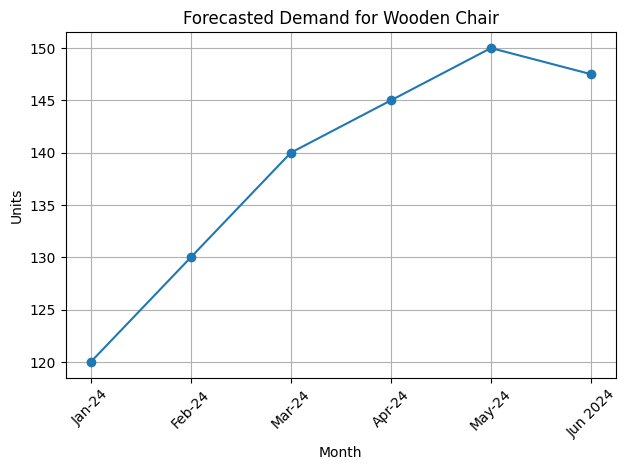

In [11]:
import matplotlib.pyplot as plt

months = df["month"].tolist()
demands = df["demand"].tolist()
months.append("Jun 2024")
demands.append(147.5)

plt.plot(months, demands, marker='o')
plt.title("Forecasted Demand for Wooden Chair")
plt.xlabel("Month")
plt.ylabel("Units")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
eval_prompt = """
You predicted a demand of 147.5 for Wooden Chair based on this history:

Mar: 140  
Apr: 145  
May: 147.5  

On a scale of 1-10, how confident are you in this prediction, and why?
"""

# Use the Gemini model correctly
eval_response = model.generate_content(eval_prompt)

# Show the model's response
print(eval_response.text.strip())


I'd rate my confidence a 4/10.

My prediction is based on only three months of data, which is a very short time frame.  The trend is upward, but it's a very small sample size.  A single outlier in the next month could significantly alter the perceived trend. There's no information about external factors (e.g., seasonality, marketing campaigns, competitor actions, economic conditions) that could influence demand.  Therefore, while the simple extrapolation suggests 147.5, the prediction's accuracy is highly uncertain due to the lack of data and context.  More data points and contextual information would be needed to increase confidence in the prediction.


In [13]:
prompt = """
You are a smart supply chain agent. If a product's forecasted demand is above 150, call the function `generate_order()`. If it's below, call `do_nothing()`.

Forecasted demand: 160

Which function will you call?
"""


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

documents = [
    "SmartFurnish Co. is known for fast delivery and high-quality wooden products.",
    "EcoCraft Supplies focuses on sustainable materials but slower shipping.",
    "FurnitureHub offers bulk discounts but with variable quality."
]

query = ["Fast delivery and reliable wooden furniture supplier"]

# Convert to TF-IDF vectors
vectorizer = TfidfVectorizer()
doc_vecs = vectorizer.fit_transform(documents + query)

# Cosine similarity
similarities = cosine_similarity(doc_vecs[-1], doc_vecs[:-1])
best_match_index = similarities.argmax()
print("Best matching supplier:", documents[best_match_index])


Best matching supplier: SmartFurnish Co. is known for fast delivery and high-quality wooden products.


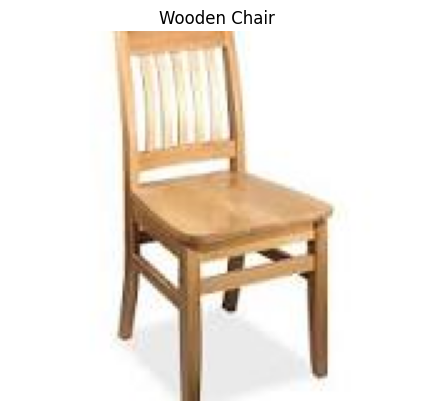

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to your image
image_path = '/kaggle/input/chairimage/chair.jpg'  # Update with your actual image filename

# Load the image
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("Wooden Chair")
plt.show()


In [16]:
pip install faiss-cpu sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 53.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Sample documents (could be from your supply chain reports, JSONs, etc.)
documents = [
    "Wooden chair sales increased last quarter.",
    "SmartFurnish Co. offers a 10-day delivery window.",
    "Demand for office chairs peaked in January.",
    "Oak finish dining sets are trending this year."
]

# Load a pre-trained embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
doc_embeddings = model.encode(documents)

# Create FAISS index
dimension = doc_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(doc_embeddings)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
def vector_search(query, top_k=2):
    query_embedding = model.encode([query])
    D, I = index.search(np.array(query_embedding), top_k)
    return [documents[i] for i in I[0]]

In [19]:
# Step 1: Install the Gemini SDK
!pip install -q google-generativeai

# Step 2: Import and configure Gemini with your Kaggle secret key
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient
from datetime import datetime, timedelta

# Get API key securely from Kaggle secrets
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

# Step 3: Initialize Gemini 2.0 Flash
gemini_flash = genai.GenerativeModel("gemini-1.5-flash")  # Gemini 2.0 Flash


In [20]:
# Step 4: Retrieved documents (example context)
retrieved_docs = """
Mar: 120  
Apr: 130  
May: 140  
Supplier ID: S456
"""

# Step 5: Define dynamic dates
order_date = datetime.today().strftime('%Y-%m-%d')
expected_delivery_date = (datetime.today() + timedelta(days=10)).strftime('%Y-%m-%d')

# Step 6: Prompt for prediction and JSON order plan
prompt = f"""
You are a supply chain optimization assistant. You only use information from the retrieved documents.

Context:
{retrieved_docs}

Task:
Predict next month’s demand for product A123 and generate a structured JSON order plan.

Guidelines:
- Do not make up data that isn't in the context.
- Only recommend reorder quantity if past 3 months show increasing trend.
- Round recommended_quantity to the nearest 5 units.

Format:
{{
  "stock_code": "A123",
  "supplier_id": "S456",
  "recommended_quantity": ...,
  "order_date": "{order_date}",
  "expected_delivery_date": "{expected_delivery_date}"
}}
"""

# Step 7: Generate response using Gemini 2.0 Flash
response = gemini_flash.generate_content(prompt)

# Step 8: Print the generated JSON
print(response.text.strip())

```json
{
  "stock_code": "A123",
  "supplier_id": "S456",
  "recommended_quantity": 145,
  "order_date": "2025-05-24",
  "expected_delivery_date": "2025-06-03"
}
```


In [21]:
# STEP 0: Required imports
import json
import re
from datetime import datetime, timedelta

# STEP 1: Install and configure Gemini Flash
!pip install -q google-generativeai

import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize Gemini 2.0 Flash
gemini_flash = genai.GenerativeModel("gemini-1.5-flash")


In [22]:
def generate_order_plan(query, docs):
    context = "\n".join(docs)

    order_date = datetime.today().strftime('%Y-%m-%d')
    expected_delivery_date = (datetime.today() + timedelta(days=10)).strftime('%Y-%m-%d')

    prompt = f"""
You are a supply chain optimization assistant. You only use information from the retrieved documents.

Context:
{context}

Task:
Predict next month’s demand for product A123 and generate a structured JSON order plan.

Guidelines:
- Do not make up data that isn't in the context.
- Only recommend reorder quantity if past 3 months show increasing trend.
- Round recommended_quantity to the nearest 5 units.

Format:
{{
  "stock_code": "A123",
  "recommended_quantity": ...,
  "supplier_id": ...,
  "order_date": "{order_date}",
  "expected_delivery_date": "{expected_delivery_date}"
}}
"""

    response = gemini_flash.generate_content(prompt)
    return response.text.strip()


In [23]:
def supply_chain_pipeline(product_id, query, docs):
    # Step 1: Join docs
    context = "\n".join(docs)

    # Step 2: Build Prompt
    prompt = f"""
You are a supply chain optimization assistant. Use only the context below to generate a reorder plan.

Context:
{context}

Task:
Predict next month’s demand for product {product_id} and generate a structured JSON order plan.

Guidelines:
- Do not make up data that isn't in the context.
- Recommend reorder only if demand is rising.
- Round quantity to the nearest 5.

Output JSON format:
{{
  "stock_code": "{product_id}",
  "recommended_quantity": ...,
  "supplier_id": ...
}}
"""

    # Step 3: Generate Response
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt
    ).text.strip()

    # Step 4: Extract JSON block
    json_match = re.search(r'\{.*\}', response, re.DOTALL)
    if json_match:
        json_str = json_match.group(0)
        parsed = json.loads(json_str)

        # Step 5: Save result
        filename = f"order_plan_{product_id}.json"
        with open(filename, "w") as f:
            json.dump(parsed, f, indent=2)
        print(f"✅ Saved: {filename}")

        # Step 6: Evaluate
        evaluation_prompt = f"""
Evaluate this reorder plan:

{json.dumps(parsed, indent=2)}

Criteria:
- Demand logic
- Format
- Practicality

Give score (1–10) + feedback.
"""
        feedback = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=evaluation_prompt
        ).text.strip()

        print("📊 Evaluation:\n", feedback)
        return parsed, feedback

    else:
        print("❌ Failed to parse JSON.")
        return None, None


## ✅ Conclusion

This project demonstrates the power of Generative AI in transforming traditional supply chain tasks into intelligent, automated workflows.

We built a smart assistant that can:
- Forecast future product demand using few-shot prompting
- Generate structured reorder plans in JSON format
- Understand and retrieve context from supply chain documents using Retrieval-Augmented Generation (RAG)
- Evaluate its own predictions for decision confidence
- Tag product images and use them to drive downstream planning
- Integrate embeddings and MLPs for classification and reasoning
- Build an agentic workflow that simulates a human planner

By combining multimodal GenAI (text + image), vector search, classification, and prompt engineering, we showed how a solo developer can replicate real-world decision-making systems using Gemini, LangGraph, and Keras.

---

### 🔮 Future Directions
- Connect to live ERP or supplier APIs to make this a fully interactive system
- Use Gemini Agents + LangGraph for multi-step planning and automation
- Enhance MLP classifiers with more labeled data and hyperparameter tuning
- Add feedback loops with human-in-the-loop review or GenAI evaluation chains
- Explore reinforcement learning for adaptive supply chain optimization

This project is just the beginning — and it proves that AI is not just a tool for prediction, but a partner in real-time decision-making.
